# Benchmarking algorithms 

* Apply a selection of algorithms to synthetic data in order to evaluate performance with respect to reconstructing artificial systems built from characteristics of test data. 
* Using Jaccard Index as score metric.

In [1]:
import os

import testsets
import algorithms
import model_selection

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.externals import joblib
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.cluster.bicluster import SpectralCoclustering

# To specify `fit model` param of R Plaid algorithm.
import rpy2.robjects as robjects

plt.rcParams['font.size'] = 16
plt.rcParams['axes.facecolor'] = 'white'

%matplotlib inline

In [2]:
def model_dump(exp_id, experiment, parent='./../_model_dumps/'):

    for test_class, model in experiment.best_setup.items():
        stem = ('').join((exp_id, test_class, '.pkl'))
        joblib.dump(
            model, os.path.join(parent, stem)
        )

In [3]:
# Globals
SEED = 0

## Test data gallery

Load characteristics of reference data 

In [4]:
data_feats = pd.read_csv(
    './../data/data_id/data_characteristics.csv', sep='\t', index_col=0
)
data_feats

,max,min,std,nrows,ncols,nonzeros
orig_prep_pvalues,73.435290,7.079401e-09,5.889983,2664,27561,73422504
sel_prep_pvalues,73.435290,0.000000e+00,2.897937,2664,27561,739608
orig_prep_pcc,0.852443,-8.669647e-01,0.323260,2664,27561,73422504
sel_prep_pcc,0.852443,-8.669647e-01,0.063930,2664,27561,739608


### Biclusters

Illustrations of bicluster test data.

In [5]:
bic_sample_data, _, _ = testsets.gen_testsets(
    data_feats, sparse=[False, True, False, True],
    non_neg=[True, True, False, False],
    shape=(500, 300), n_clusters=3, seed=SEED,
    kind='bicluster'
)

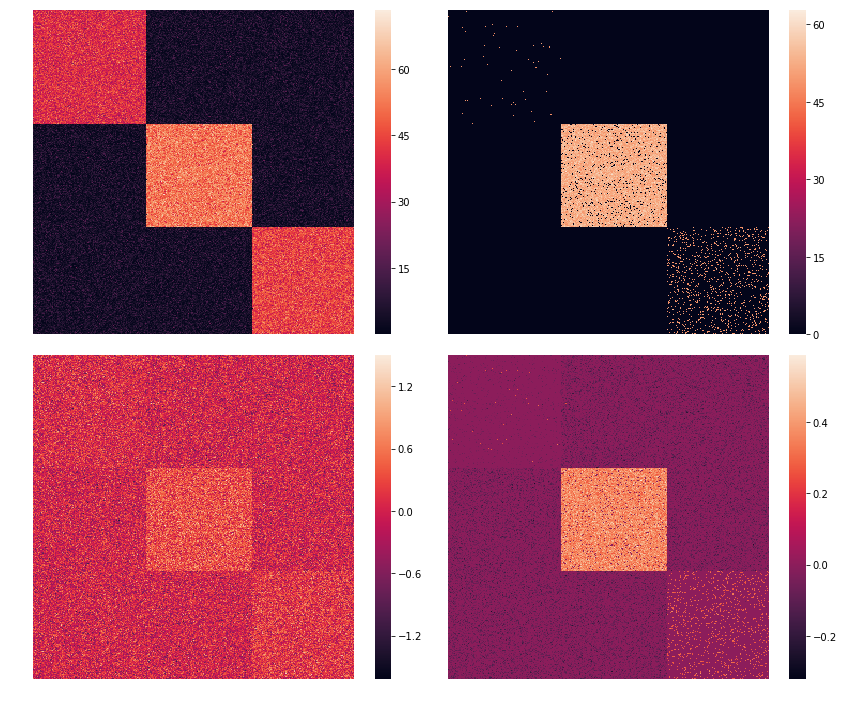

In [6]:
nrows, ncols = 2, 2
labels = list(bic_sample_data.keys())

fig, axes = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(12, 10), sharey=True, sharex=True
)
num = 0
for row in range(nrows):
    for col in range(ncols):
        _data = bic_sample_data[labels[num]]
        sns.heatmap(
            _data, ax=axes[row, col], cbar=True,
            vmin=np.min(_data), vmax=np.max(_data)
        )
        #axes[row, col].set_title(labels[num])
        axes[row, col].axis('off')
        
        num += 1
        
plt.tight_layout()

### Checkerboards

Illustrations of checkerboard test data.

In [18]:
check_sample_data, _, _ = testsets.gen_testsets(
    data_feats, sparse=[False, True, False, True],
    non_neg=[True, True, False, False],
    shape=(500, 300), n_clusters=(2, 2), seed=SEED,
    kind='checkerboard'
)

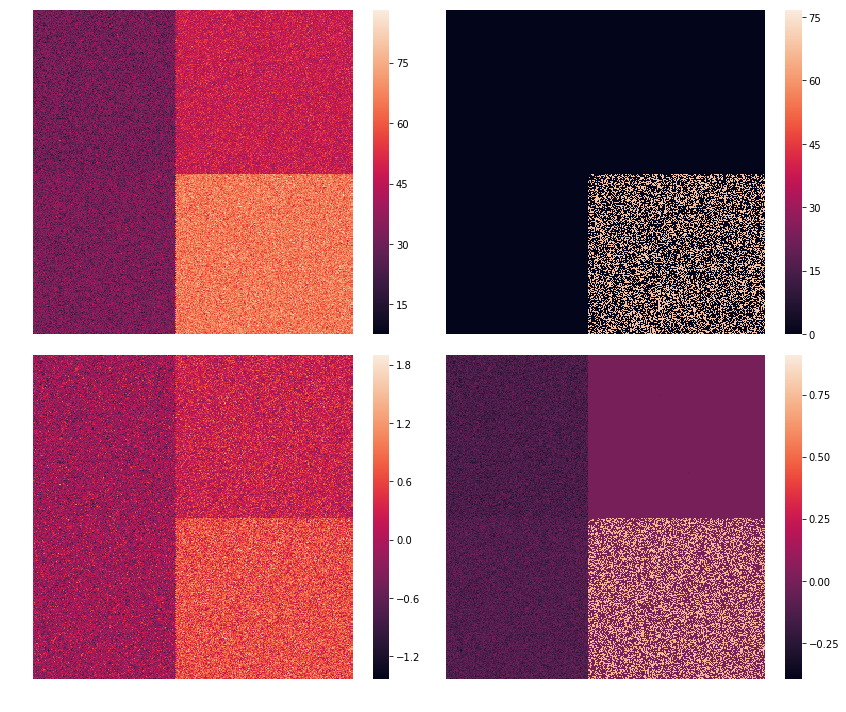

In [19]:
nrows, ncols = 2, 2
labels = list(check_sample_data.keys())

fig, axes = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(12, 10), sharey=True, sharex=True
)
num = 0
for row in range(nrows):
    for col in range(ncols):
        _data = check_sample_data[labels[num]]
        sns.heatmap(
            _data, ax=axes[row, col], cbar=True,
            vmin=np.min(_data), vmax=np.max(_data)
        )
        axes[row, col].axis('off')
        
        num += 1
        
plt.tight_layout()

## Experiments

Generate test data of fixed array size with various numbers of target clusters across four distinct classes of data characteristics.

In [5]:
# NOTE: The reference data contains approx. ten times more rows than columns.
array_size = (1000, 100)
# Generating block diagonal bicluster test data.
n_bic_clusters = np.arange(5) + 2
bic_exp_data = [
    # NOTE: Each list element is a tuple of data, rows, cols
    testsets.gen_testsets(
        data_feats, sparse=[False, True, False, True], 
        non_neg=[True, True, False, False],
        shape=array_size, n_clusters=num, seed=SEED,
        kind='bicluster'
    ) 
    for num in n_bic_clusters
]

# Generating checkerboard test data.
n_check_clusters = [(2, 2), (3, 4), (5, 4)]
check_exp_data = [
    # NOTE: Each list element is a tuple of data, rows, cols
    testsets.gen_testsets(
        data_feats, sparse=[False, True, False, True], 
        non_neg=[True, True, False, False],
        shape=array_size, n_clusters=num, seed=SEED,
        kind='checkerboard'
    ) 
    for num in n_check_clusters
]

In [38]:
# Write test data setup of LaTex table.
"""
items = pd.DataFrame(
    np.zeros((4 * n_bic_clusters.size, 3), dtype=float), 
    columns=['min', 'max', 'std'],
    index=pd.MultiIndex.from_product(
        (n_bic_clusters, ['class1', 'class2', 'class3', 'class4']),
        names=('test_class', 'n_clusters')
    )
)
row_loc = 0
for set_num, (data, rows, cols) in enumerate(bic_exp_data):
    
    keys = list(data.keys())
    for key_num, key in enumerate(keys):
        items.iloc[row_loc, :] = [np.min(data[key]), np.max(data[key]), np.std(data[key])]
        row_loc += 1
items.to_latex(
    './../predictions/test_data_stats.tex'
)"""

### Scikit-learn spectral 

Setup scikit-learn algorithms and hyperparameter grids

In [16]:
sk_models_and_params = [
    (
        SpectralBiclustering, {
            'method': ['log', 'bistochastic', 'scale'], 
            'mini_batch': [True, False],
        }
    ),
    (
        SpectralCoclustering, {
            'mini_batch': [True, False],
        }
    )
]

#### Bicluster test data

In [21]:
# NOTE: Verbose in [0, 1, 2]

# Experimental setup
sk_multi_exper = model_selection.MultiExperiment(
    sk_models_and_params, n_clusters=n_bic_clusters,
    verbose=2, random_state=SEED
)
# NOTE: Using Jaccard Index as metric.
sk_multi_exper.execute_all(
    bic_exp_data, data_feats.index, metric='jaccard'
);

Dataset number: 1
Experiment initiated:
---------------------
Training set: `orig_prep_pvalues`
Model performance:
Name: SpectralBiclustering
Score: 0.5

Model performance:
Name: SpectralCoclustering
Score: 1.0

Best model: SpectralCoclustering
Score: 1.0

Training set: `sel_prep_pvalues`
Model performance:
Name: SpectralBiclustering
Score: 0.5

Model performance:
Name: SpectralCoclustering
Score: 1.0

Best model: SpectralCoclustering
Score: 1.0

Training set: `orig_prep_pcc`
Model performance:
Name: SpectralBiclustering
Score: 0.5

Model performance:
Name: SpectralCoclustering
Score: 1.0

Best model: SpectralCoclustering
Score: 1.0

Training set: `sel_prep_pcc`
Model performance:
Name: SpectralBiclustering
Score: 0.5

Model performance:
Name: SpectralCoclustering
Score: 1.0

Best model: SpectralCoclustering
Score: 1.0

Dataset number: 2
Experiment initiated:
---------------------
Training set: `orig_prep_pvalues`
Model performance:
Name: SpectralBiclustering
Score: 0.3333333333333333


In [18]:
print('Performance report sklearn models:\n')
print(sk_multi_exper.performance_report)

Performance report sklearn models:

                                  model  score_avg  score_std
test_class                                                   
orig_prep_pvalues  SpectralCoclustering   0.892851   0.134524
sel_prep_pvalues   SpectralCoclustering   0.795774   0.247079
orig_prep_pcc      SpectralCoclustering   0.593790   0.303002
sel_prep_pcc       SpectralCoclustering   0.737474   0.235457


In [25]:
sk_multi_exper.model_votes

{'orig_prep_pvalues': {'SpectralBiclustering': 0, 'SpectralCoclustering': 5},
 'sel_prep_pvalues': {'SpectralBiclustering': 0, 'SpectralCoclustering': 5},
 'orig_prep_pcc': {'SpectralBiclustering': 0, 'SpectralCoclustering': 5},
 'sel_prep_pcc': {'SpectralBiclustering': 0, 'SpectralCoclustering': 5}}

In [13]:
# Write instances of winning models to disk.
model_dump(exp_id='sk_checker_', experiment=sk_multi_exper)

#### Checkerboard test data

In [14]:
# Experimental setup
sk_multi_exper = model_selection.MultiExperiment(
    sk_models_and_params, n_clusters=n_check_clusters,
    verbose=1, random_state=SEED
)
# NOTE: Using Jaccard Index as metric.
sk_multi_exper.execute_all(
    check_exp_data, data_feats.index, metric='jaccard'
);

NameError: name 'sk_models_and_params' is not defined

In [15]:
print('Performance report sklearn models:\n')
print(sk_multi_exper.performance_report)

Performance report sklearn models:

                                  model  score_avg  score_std
test_class                                                   
orig_prep_pvalues  SpectralBiclustering   0.778033   0.159491
sel_prep_pvalues   SpectralBiclustering   0.774167   0.163330
orig_prep_pcc      SpectralBiclustering   0.778135   0.159442
sel_prep_pcc       SpectralBiclustering   0.778548   0.159246


In [16]:
# Write instances of winning models to disk.
model_dump(exp_id='sk_bic_', experiment=sk_multi_exper)

### R biclust 

Setup R algorithms and hyperparameter grids. see [R biclust docs](https://cran.r-project.org/web/packages/biclust/biclust.pdf) for param description.

In [9]:
r_models_and_params = [
    (
        algorithms.Quest, {
            'ns': [10, 50, 100],
            'nd': [10, 50],
            'alpha': [0.08, 0.1],
        }
    ), (
        algorithms.Bimax, {
            'minr': [50, 100, 500],
            'minc': [50, 100, 500],
        }
    ), (
        algorithms.ChengChurch, {
            'delta': [0.1, 0.5, 1.0],
            'alpha': [1., 1.5, 2.],
        }
    ), (
        algorithms.Plaid, {
            'fit_model': [
                robjects.r('y ~ m + a + b'),
                robjects.r('y ~ (a - b)^2 / (2 * m^2)')
            ],
            'row_release': [0.3, 0.7],
            'col_release': [0.3, 0.7],
        }
    ), (
        algorithms.Xmotifs, {
            'ns': [100, 500],
            'nd': [5, 10, 20],
            'alpha': [0.08, 0.1],
        }
    ), (
        algorithms.Spectral, {
            'normalization': ['log', 'bistochastization'],
            'numberOfEigenvalues': [3, 5, 8],
        }
    )
]

#### Bicluster test data

In [20]:
# NOTE: Verbose in [0, 1, 2]

# NOTE: Option to run verbose.
r_multi_exper = model_selection.MultiExperiment(
    r_models_and_params, n_clusters=n_bic_clusters,
    verbose=2, random_state=SEED
)
# NOTE: Using Jaccard Index as metric.
r_multi_exper.execute_all(
    bic_exp_data, data_feats.index, metric='jaccard'
)

Dataset number: 1
Experiment initiated:
---------------------
Training set: `orig_prep_pvalues`
Model performance:
Name: Quest
Score: 0.0

Model performance:
Name: Bimax
Score: 0.7403846153846154

Model performance:
Name: ChengChurch
Score: 0.1326

Model performance:
Name: Plaid
Score: 0.5

Model performance:
Name: Xmotifs
Score: 0.0011011924157051307

Model performance:
Name: Spectral
Score: 0.004023881653387458

Best model: Bimax
Score: 0.7403846153846154

Training set: `sel_prep_pvalues`
Model performance:
Name: Quest
Score: 0.26

Model performance:
Name: Bimax
Score: 0.25817519079621826

Model performance:
Name: ChengChurch
Score: 0.272272797298098

Model performance:
Name: Plaid
Score: 0.0

Model performance:
Name: Xmotifs
Score: 0.255

Model performance:
Name: Spectral
Score: 0.014945433003958503

Best model: ChengChurch
Score: 0.272272797298098

Training set: `orig_prep_pcc`
Model performance:
Name: Quest
Score: 0.0

Model performance:
Name: Bimax
Score: 0.0057631170634436435

M

Model performance:
Name: Bimax
Score: 0.021619716666066064

Model performance:
Name: ChengChurch
Score: 0.030109145652992095

Model performance:
Name: Plaid
Score: 0.14583333333333334

Model performance:
Name: Xmotifs
Score: 0.0

Model performance:
Name: Spectral
Score: 0.02639656230816452

Best model: Plaid
Score: 0.14583333333333334



In [11]:
print('Performance report R models:\n')
print(r_multi_exper.performance_report)

Performance report R models:

                         model  score_avg  score_std
test_class                                          
orig_prep_pvalues        Plaid   0.497254   0.126364
sel_prep_pvalues   ChengChurch   0.119435   0.110261
orig_prep_pcc            Bimax   0.005624   0.001432
sel_prep_pcc       ChengChurch   0.146142   0.086838


In [23]:
# the scores for each algorithmn in round one to five: 
r_multi_exper._tracker.model_scores

{'orig_prep_pvalues': {'Quest': [],
  'Bimax': [0.7403846153846154, 0.6666666666666666],
  'ChengChurch': [],
  'Plaid': [0.61875, 0.55, 0.3230119634060521],
  'Xmotifs': [],
  'Spectral': []},
 'sel_prep_pvalues': {'Quest': [0.10536709938869165],
  'Bimax': [],
  'ChengChurch': [0.272272797298098,
   0.016243339927893823,
   0.06978867753510119],
  'Plaid': [0.22862368541380887],
  'Xmotifs': [],
  'Spectral': []},
 'orig_prep_pcc': {'Quest': [],
  'Bimax': [0.0057631170634436435,
   0.006344895591125062,
   0.007104176890130343,
   0.0032846447379664355],
  'ChengChurch': [],
  'Plaid': [],
  'Xmotifs': [],
  'Spectral': [0.008982223752294533]},
 'sel_prep_pcc': {'Quest': [],
  'Bimax': [0.019686746810405803],
  'ChengChurch': [0.23298091799896853, 0.059304025991542005],
  'Plaid': [0.18084066471163243, 0.14583333333333334],
  'Xmotifs': [],
  'Spectral': []}}

In [26]:
# the number of votes for each algorithmn in round one to five: 
r_multi_exper.model_votes

{'orig_prep_pvalues': {'Quest': 0,
  'Bimax': 2,
  'ChengChurch': 0,
  'Plaid': 3,
  'Xmotifs': 0,
  'Spectral': 0},
 'sel_prep_pvalues': {'Quest': 1,
  'Bimax': 0,
  'ChengChurch': 3,
  'Plaid': 1,
  'Xmotifs': 0,
  'Spectral': 0},
 'orig_prep_pcc': {'Quest': 0,
  'Bimax': 4,
  'ChengChurch': 0,
  'Plaid': 0,
  'Xmotifs': 0,
  'Spectral': 1},
 'sel_prep_pcc': {'Quest': 0,
  'Bimax': 1,
  'ChengChurch': 2,
  'Plaid': 2,
  'Xmotifs': 0,
  'Spectral': 0}}

In [20]:
# Write instances of winning models to disk.
model_dump(exp_id='r_bic_', experiment=r_multi_exper)

#### Checkerboard test data

In [21]:
# Experimental setup
r_multi_exper = model_selection.MultiExperiment(
    r_models_and_params, n_clusters=n_check_clusters,
    verbose=2, random_state=SEED
)
# NOTE: Using Jaccard Index as metric.
r_multi_exper.execute_all(
    check_exp_data, data_feats.index, metric='jaccard'
);

Dataset number: 1
Experiment initiated:
---------------------
Training set: `orig_prep_pvalues`
Model performance:
Name: Quest
Score: 0.0

Model performance:
Name: Bimax
Score: 0.23555761507568737

Model performance:
Name: ChengChurch
Score: 0.14893836582503747

Model performance:
Name: Plaid
Score: 0.8695792414650899

Model performance:
Name: Xmotifs
Score: 0.0

Model performance:
Name: Spectral
Score: 0.0021115938130797135

Best model: Plaid
Score: 0.8695792414650899

Training set: `sel_prep_pvalues`
Model performance:
Name: Quest
Score: 0.17111791540819005

Model performance:
Name: Bimax
Score: 0.0

Model performance:
Name: ChengChurch
Score: 0.10755735744280925

Model performance:
Name: Plaid
Score: 0.25

Model performance:
Name: Xmotifs
Score: 0.2812691106200818

Model performance:
Name: Spectral
Score: 0.005999122061515334

Best model: Xmotifs
Score: 0.2812691106200818

Training set: `orig_prep_pcc`
Model performance:
Name: Quest
Score: 0.0

Model performance:
Name: Bimax
Score: 

In [22]:
print('Performance report R models:\n')
print(r_multi_exper.performance_report)

Performance report R models:

                   model  score_avg  score_std
test_class                                    
orig_prep_pvalues  Plaid   0.516819   0.253384
sel_prep_pvalues   Plaid   0.226788   0.024587
orig_prep_pcc      Plaid   0.397853   0.163693
sel_prep_pcc       Plaid   0.447279   0.114993


In [23]:
# Write instances of winning models to disk.
model_dump(exp_id='r_checker_', experiment=r_multi_exper)